In [1]:
# ===== 0) Setup =====
!pip -q install tqdm scikit-learn

import os, time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
# getting allt he path way fixed
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1"
PT_PATH   = "/content/drive/MyDrive/Colab Notebooks/model3_best.pt"

IMAGES_DIR  = os.path.join(DATA_ROOT, "images")
TRAIN_TXT   = os.path.join(DATA_ROOT, "images_manufacturer_train.txt")
VAL_TXT     = os.path.join(DATA_ROOT, "images_manufacturer_val.txt")
TEST_TXT    = os.path.join(DATA_ROOT, "images_manufacturer_test.txt")
CLASSES_TXT = os.path.join(DATA_ROOT, "manufacturers.txt")

print("\nDATA_ROOT:", DATA_ROOT)
print("IMAGES_DIR exists :", os.path.isdir(IMAGES_DIR))
print("TRAIN_TXT exists  :", os.path.exists(TRAIN_TXT))
print("VAL_TXT exists    :", os.path.exists(VAL_TXT))
print("TEST_TXT exists   :", os.path.exists(TEST_TXT))
print("CLASSES_TXT exists:", os.path.exists(CLASSES_TXT))



DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/CVNL_Assignment1
IMAGES_DIR exists : True
TRAIN_TXT exists  : True
VAL_TXT exists    : True
TEST_TXT exists   : True
CLASSES_TXT exists: True


In [4]:
# ===== 2) Classes =====
with open(CLASSES_TXT, "r") as f:
    classes = [line.strip() for line in f if line.strip()]

class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

num_classes = len(classes)
print("num_classes =", num_classes)
print("first 5 classes:", classes[:5])


num_classes = 30
first 5 classes: ['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing']


In [5]:
# ===== 3) Dataset =====
class FGVCManufacturerDataset(Dataset):
    def __init__(self, txt_path, images_dir, class_to_idx, transform=None):
        self.images_dir = images_dir
        self.class_to_idx = class_to_idx
        self.transform = transform

        self.samples = []
        with open(txt_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                img_id = parts[0]
                label = " ".join(parts[1:])
                self.samples.append((img_id, label))

# just for viewing
        print("Loaded samples:", len(self.samples))
        print("Example:", self.samples[0])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_id, label = self.samples[idx]
        img_path = os.path.join(self.images_dir, img_id + ".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        y = self.class_to_idx[label]
        return image, y, img_id


In [6]:
import torchvision.transforms as T

IMG_SIZE = 224

test_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


In [7]:
# ===== 5) Loader =====
test_ds = FGVCManufacturerDataset(TEST_TXT, IMAGES_DIR, class_to_idx, transform=test_tfms)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Loaded samples: 3333
Example: ('1514522', 'Boeing')


In [8]:
import torch, torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

ckpt = torch.load(PT_PATH, map_location="cpu")
print("ckpt keys:", ckpt.keys())

sd = ckpt["model_state"]
ckpt_class_names = ckpt.get("class_names", None)
img_size = ckpt.get("img_size", 224)
banner_px = ckpt.get("banner_px", 0)

print("ckpt img_size :", img_size)
print("ckpt banner_px:", banner_px)
if ckpt_class_names is not None:
    print("ckpt class_names:", ckpt_class_names)


keys = list(sd.keys())
print("\nFirst 25 state_dict keys:")
for k in keys[:25]:
    print(" ", k)

def guess_arch(sd_keys):
    s = set(sd_keys)

    if any(k.startswith("layer1.") for k in s) and any(k.startswith("fc.") for k in s):
        return "resnet"

    if any(k.startswith("features.") for k in s) and any(k.startswith("classifier.") for k in s):
        return "simplecnn"
    if any("backbone" in k for k in s) and any("head" in k for k in s):
        return "backbone_head"
    return "unknown"

arch = guess_arch(keys)
print("\nGuessed architecture:", arch)


num_classes = len(classes)

model = None

if arch == "resnet":

    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

elif arch == "simplecnn":
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
                nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
                nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
                nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1,1))
            )
            self.classifier = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.features(x)
            x = x.flatten(1)
            return self.classifier(x)

    model = SimpleCNN(num_classes)

else:
    raise RuntimeError(
        "Couldn't infer your model architecture from state_dict keys.\n"
        "Paste the FIRST ~40 sd keys (printed above) and I’ll rebuild the exact model."
    )


try:
    model.load_state_dict(sd, strict=True)
    print("Loaded state_dict with strict=True")
except RuntimeError as e:
    print("strict=True failed oh no ")
    print(e)
    print("\nTrying strict=False...")
    missing, unexpected = model.load_state_dict(sd, strict=False)
    print("Loaded with strict=False ")
    print("Missing keys   :", missing[:20], "..." if len(missing) > 20 else "")
    print("Unexpected keys:", unexpected[:20], "..." if len(unexpected) > 20 else "")

model = model.to(device).eval()
print("Model ready ")


device: cpu
ckpt keys: dict_keys(['model_state', 'class_names', 'img_size', 'banner_px', 'notes'])
ckpt img_size : 224
ckpt banner_px: 20
ckpt class_names: ['ATR', 'Airbus', 'Antonov', 'Beechcraft', 'Boeing', 'Bombardier Aerospace', 'British Aerospace', 'Canadair', 'Cessna', 'Cirrus Aircraft', 'Dassault Aviation', 'Dornier', 'Douglas Aircraft Company', 'Embraer', 'Eurofighter', 'Fairchild', 'Fokker', 'Gulfstream Aerospace', 'Ilyushin', 'Lockheed Corporation', 'Lockheed Martin', 'McDonnell Douglas', 'Panavia', 'Piper', 'Robin', 'Saab', 'Supermarine', 'Tupolev', 'Yakovlev', 'de Havilland']

First 25 state_dict keys:
  conv1.weight
  bn1.weight
  bn1.bias
  bn1.running_mean
  bn1.running_var
  bn1.num_batches_tracked
  layer1.0.conv1.weight
  layer1.0.bn1.weight
  layer1.0.bn1.bias
  layer1.0.bn1.running_mean
  layer1.0.bn1.running_var
  layer1.0.bn1.num_batches_tracked
  layer1.0.conv2.weight
  layer1.0.bn2.weight
  layer1.0.bn2.bias
  layer1.0.bn2.running_mean
  layer1.0.bn2.running_var

In [9]:
import torchvision.transforms as T

class TopCrop:
    def __init__(self, px=0):
        self.px = int(px or 0)
    def __call__(self, img):
        if self.px <= 0:
            return img
        w, h = img.size
        return img.crop((0, self.px, w, h))

test_tfms = T.Compose([
    TopCrop(px=banner_px),
    T.Resize((img_size, img_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


test_ds = FGVCManufacturerDataset(TEST_TXT, IMAGES_DIR, class_to_idx, transform=test_tfms)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


Loaded samples: 3333
Example: ('1514522', 'Boeing')


In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

all_y, all_p, all_ids = [], [], []
t0 = time.time()

model.eval()
with torch.no_grad():
    for x, y, img_ids in tqdm(test_loader, desc="testing"):
        x = x.to(device, non_blocking=True)

        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_p.append(preds)
        all_y.append(y.numpy())
        all_ids.extend(list(img_ids))

all_y = np.concatenate(all_y)
all_p = np.concatenate(all_p)

acc = accuracy_score(all_y, all_p)
f1m = f1_score(all_y, all_p, average="macro")
f1w = f1_score(all_y, all_p, average="weighted")

print(f"Test samples : {len(all_y)}")
print(f"Accuracy     : {acc:.4f}")
print(f"F1 (macro)   : {f1m:.4f}")
print(f"F1 (weighted): {f1w:.4f}")
print(f"Runtime      : {time.time()-t0:.2f}s")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


testing:   0%|          | 0/53 [00:00<?, ?it/s]

Test samples : 3333
Accuracy     : 0.3210
F1 (macro)   : 0.2361
F1 (weighted): 0.3131
Runtime      : 1010.18s


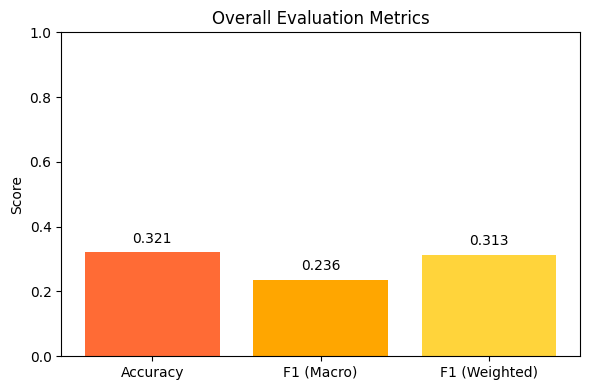

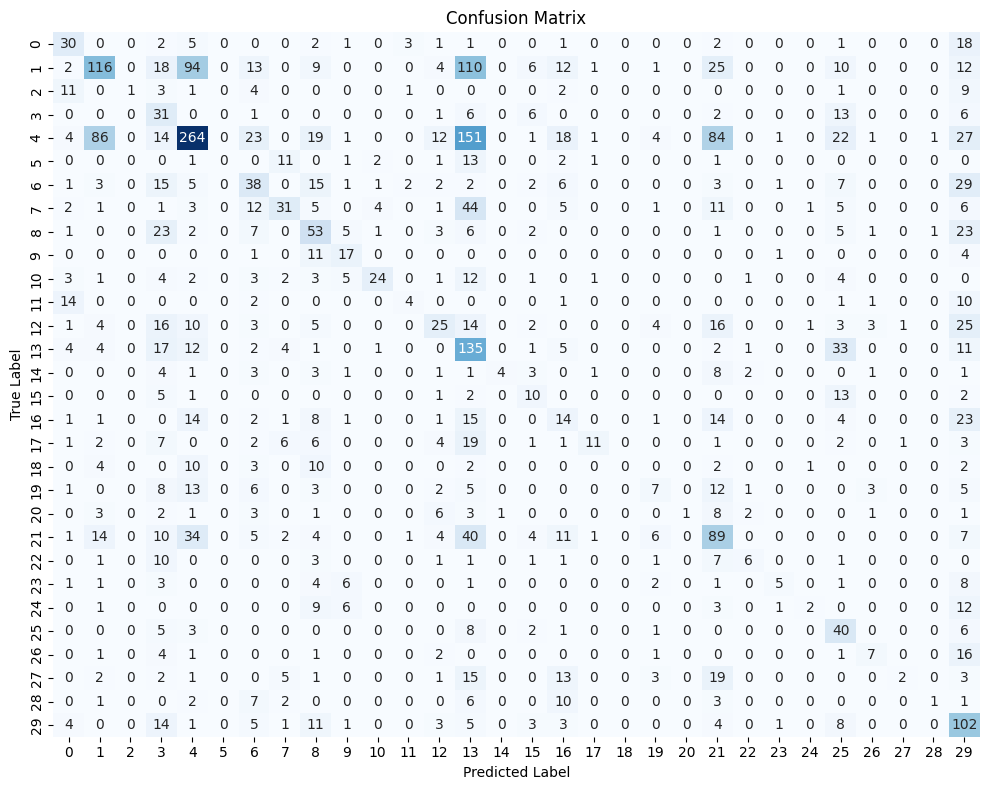

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-558585400.py:36: FutureWarning

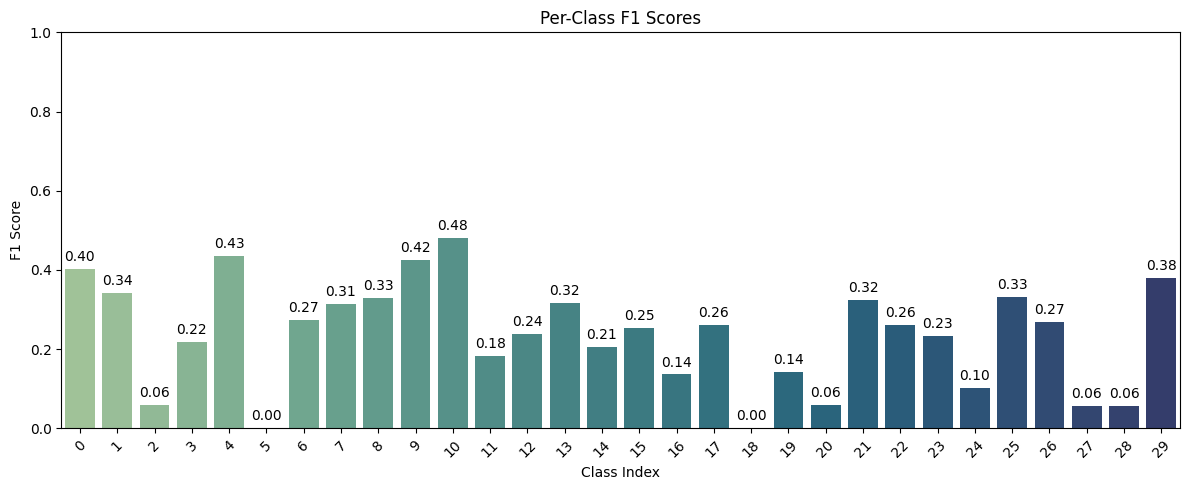

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ----------- 1. Bar Plot of Overall Metrics -----------
plt.figure(figsize=(6, 4))
metrics = [acc, f1m, f1w]
names = ["Accuracy", "F1 (Macro)", "F1 (Weighted)"]

bars = plt.bar(names, metrics, color=["#ff6b35", "#ffa600", "#ffd43b"])
plt.ylim(0, 1.0)
plt.title("Overall Evaluation Metrics")
plt.ylabel("Score")
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{yval:.3f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

# ----------- 2. Confusion Matrix -----------
cm = confusion_matrix(all_y, all_p)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ----------- 3. Per-Class F1 Scores -----------
report = classification_report(all_y, all_p, output_dict=True)
class_f1 = {k: v['f1-score'] for k, v in report.items() if k.isdigit()}

if class_f1:
    plt.figure(figsize=(12, 5))
    sns.barplot(x=list(class_f1.keys()), y=list(class_f1.values()), palette="crest")
    plt.title("Per-Class F1 Scores")
    plt.xlabel("Class Index")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)
    for i, v in enumerate(class_f1.values()):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
